In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
img = cv2.imread("./Image DataSet\lionel_messi\_111066400_messi.jpg")
img.shape

(576, 1024, 3)

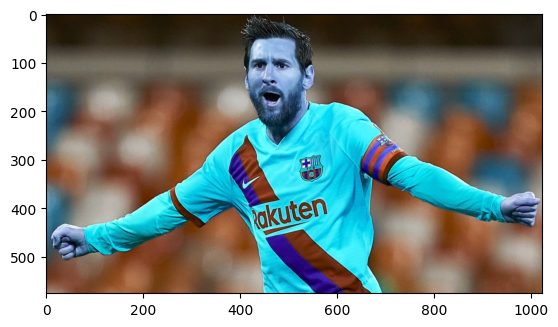

In [3]:
plt.imshow(img)

In [4]:
face_classifier = cv2.CascadeClassifier("C:/Users/jonua/opencv-4.x/data/haarcascades/haarcascade_frontalface_default.xml")
eye_classifier = cv2.CascadeClassifier("C:/Users/jonua/opencv-4.x/data/haarcascades/haarcascade_eye.xml")

In [5]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
#img_gray.shape
img.shape

(576, 1024, 3)

In [7]:
faces = face_classifier.detectMultiScale(img_gray)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [ ]:
plt.imshow(img_gray)

In [ ]:
faces

In [ ]:
x,y,w,h = faces[0]
x,y,w,h

In [ ]:
img_01 = img_gray[y : y + h, x : x + w]
plt.matshow(img_01)

In [ ]:
img_01

In [ ]:
a,b,m,n = faces[1]
img_02 = img_gray[b : b + m, a : a + n]
a,b,m,n

In [ ]:
plt.imshow(img_02)

In [ ]:
def crop_face(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 4)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_classifier.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
img_path = "./Image DataSet\lionel_messi\_111066400_messi.jpg"
faces = crop_face(img_path)
len(faces)

In [ ]:
plt.matshow(faces)

In [ ]:
path_to_images = "./Image DataSet/"
path_to_crpped = "./Cropped Images/"
import os

In [ ]:
img_folders = []
for entry in os.scandir(path_to_images):
    if entry.is_dir():
        img_folders.append(entry.path)
img_folders

In [ ]:
import shutil

In [ ]:
# if os.path.exists(path_to_crpped):
#     shutil.rmtree(path_to_crpped)
# os.mkdir(path_to_crpped)

In [ ]:
crpped_img_folders = []
celeb_folders = {}

for folder_path in img_folders:
    c = 1
    name = folder_path.split('/')[-1]
    #print(name)
    celeb_folders[name] = []
    celeb_dir = path_to_crpped + name
    #print(celeb_dir)
    if not os.path.exists(celeb_dir):
        os.mkdir(celeb_dir)
    crpped_img_folders.append(celeb_dir)
    for entry in os.scandir(folder_path):
        #print(entry)
        roi_color = crop_face(entry.path)
        if roi_color is not None:
            crpp_img_name = name + str(c) + ".jpg"
            crpp_img_path = celeb_dir +  "/" + crpp_img_name
            
            #cv2.imwrite(crpp_img_path, roi_color)
            celeb_folders[name].append(crpp_img_path)
            c = c + 1
        


In [ ]:
import pywt

In [ ]:
def wavelett_trans(img, mode='haar', level=5):
    img_arr = img
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    img_arr = np.float32(img_arr)
    img_arr = img_arr/255
    
    coeffs = pywt.wavedec2(img_arr, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    img_arr_H = pywt.waverec2(coeffs_H, mode)
    img_arr_H *= 255
    img_arr_H = np.uint8(img_arr_H)
    
    return img_arr_H

img_har = wavelett_trans(faces, 'db1', 2)
plt.matshow(img_har, cmap='gray')

In [ ]:
import joblib

In [ ]:
joblib.dump(celeb_folders, 'celeb_folders')

In [ ]:
encode_celeb = {}
c = 0

for name in celeb_folders:
    encode_celeb[name] = c
    c += 1
encode_celeb

In [ ]:
X = []
Y = []
for celeb, path in celeb_folders.items():
    if not path:
        continue
    for train_data in path:
        img_train = cv2.imread(train_data)
        if img_train is None:
            continue
        scaled_raw_img = cv2.resize(img_train, (32,32))
        img_har = wavelett_trans(img_train, level=5)
        scaled_har_img = cv2.resize(img_har, (32,32))
        stack_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_har_img.reshape(32*32, 1)))
        X.append(stack_img)
        Y.append(encode_celeb[celeb])

In [ ]:
joblib.dump(X, 'X')
joblib.dump(Y, 'Y')

In [ ]:
len(X[0])

In [ ]:
32*32*3 + 32*32

In [ ]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=40, test_size=0.3)
pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SVC(C=10, kernel='rbf'))])
pipe.fit(X_train, Y_train)
pipe.score(X_test, Y_test)

In [ ]:
print(classification_report(Y_test, pipe.predict(X_test)))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


In [ ]:
model_params = {
    'svm' : {
        'model' : SVC(gamma='auto', probability=True),
        'params' : {
            'svc__C' : [1,10,100,100],
            'svc__kernel' : ['rbf', 'linear', 'poly', 'sigmoid']
        }
    },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators' : [1,3,5,100]
        }
    },
    'logistic_regression': {
        'model' : LogisticRegression(),
        'params' : {
            'logisticregression__solver' : [ 'newton-cg', 'sag', 'saga'],
            'logisticregression__C' : [1, 10, 20]
        }
    }
}

In [ ]:
scores = []
best_esmti = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, Y_train)
    scores.append({
        'model' : algo,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })
    best_esmti[algo] = clf.best_estimator_
df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

In [ ]:
parameters = {
    "learning_rate":[0.01,0.1,1.0,10,100],
    "n_estimators":[5,50,250,500]
}

ada_cv = GridSearchCV(AdaBoostClassifier(), parameters, cv=5)
ada_cv.fit(X_train,Y_train)

ada = ada_cv.best_estimator_
ada.fit(X_train,Y_train)

In [ ]:
ada.score(X_test, Y_test)

In [ ]:
# parameters = {  
#     "boosting_type":["gbdt","dart","goss","rf"],
#     "learning_rate":[0.01,0.1,1.0,10,100],
#     "max_depth":[2,4,8,16,32],
#     "n_estimators":[5,50,250,500]
# }

# lgbm_cv = GridSearchCV(LGBMClassifier(), parameters, cv=5)
# lgbm_cv.fit(X_train,Y_train)

# lgbm = lgbm_cv.best_estimator_
# lgbm.fit(X_train,Y_train)

In [ ]:
parameters = {
    "algorithm":["ball_tree","kd_tree","brute"],
    "metric":["minkowski","euclidean","manhattan"],
    "n_neighbors":range(2,21),
    "weights":["uniform","distance"]
}

knn_cv = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)
knn_cv.fit(X_train,Y_train)

knn = knn_cv.best_estimator_
knn.fit(X_train,Y_train)
knn.score(X_test, Y_test)

In [ ]:
df['best_params'][2]

In [ ]:
pipe_LR = Pipeline([('scaler', StandardScaler()) , ('LR_classifier', LogisticRegression(solver='newton-cg', C=1))]) 

In [ ]:
pipe_LR.fit(X_train, Y_train)

In [ ]:
pipe_LR.score(X_test, Y_test)

In [ ]:
y_pred = pipe_LR.predict(X_test)

In [ ]:
print(classification_report(Y_test, y_pred))

In [ ]:
import joblib

In [ ]:
joblib.dump(pipe_LR, 'Model_LR_Demo.sav')

In [ ]:
best_clfier = best_esmti['logistic_regression']
best_clfier.score(X_test, Y_test)

In [ ]:
y_pred = best_clfier.predict(X_test)

In [ ]:
print(classification_report(y_pred, Y_test))

In [ ]:
svm = best_esmti['svm']

In [ ]:
svm.score(X_test, Y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(confusion_matrix(Y_test, y_pred))

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True)

In [ ]:
import json

In [ ]:
with open('class_dict.json', "w") as f:
    f.write(json.dumps(encode_celeb))